In [1]:
%reset -f

In [2]:
import numpy as np
import osmnx as ox
import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx as ox
import folium
import json
import h3
from shapely.geometry import Polygon, Point
from shapely import wkt
from itertools import permutations
from geopy.distance import geodesic

In [3]:
city_name = 'Montpellier'

In [4]:
# Extracts latitude and longitude coordinates from a GeoDataFrame of geometries.
def get_coordinate(geoms):
    
    # Extract longitude for Point geometries, centroid longitude for Polygon geometries
    long = geoms.apply(lambda x: x.x if x.geom_type == 'Point' else x.centroid.x)
    
    # Extract latitude for Point geometries, centroid latitude for Polygon geometries
    lat = geoms.apply(lambda x: x.y if x.geom_type == 'Point' else x.centroid.y)
    
    return lat, long

In [5]:
# Extracting geographical features from OpenStreetMap
def features_from_osm(tag, city):
    
    # Extract features from OpenStreetMap for the specified tag and city
    gdf = ox.features_from_place(city, tag).reset_index()
    
    # Add city, object, and type columns to the GeoDataFrame
    gdf['city'] = np.full(len(gdf), city.split(',')[0])
    gdf['object'] = np.full(len(gdf), list(tag.keys())[0])
    gdf['type'] = np.full(len(gdf), tag[list(tag.keys())[0]])
    
    # Select relevant columns
    gdf = gdf[['city', 'object', 'type', 'geometry']]

    # Group by city, object, and type, and count the number of geometries
    gdf.groupby(['city','object','type'], as_index = False).agg({'geometry':'count'})
    
    # Get coordinates for each geometry
    lat, long = get_coordinate(gdf['geometry'])
    gdf['lat'] = lat
    gdf['long'] = long
    return gdf


# Define tag with amenities to search for
tag = {'amenity': 'pharmacy'}

# List comprehension to create a list of GeoDataFrames for each tag
gdf_objects_list = [features_from_osm(tag, city_name)]

# Concatenate all GeoDataFrames in the list
gdf_pharmacy = pd.concat(gdf_objects_list, ignore_index=True)

# Print the information of objects in the city
print("Number of pharmacy in the city:", len(gdf_pharmacy))
print(gdf_pharmacy['type'].unique())
print(gdf_pharmacy.head())

Number of pharmacy in the city: 97
['pharmacy']
          city   object      type                  geometry        lat  \
0  Montpellier  amenity  pharmacy  POINT (3.88532 43.63027)  43.630273   
1  Montpellier  amenity  pharmacy  POINT (3.88149 43.62773)  43.627729   
2  Montpellier  amenity  pharmacy  POINT (3.87101 43.62965)  43.629646   
3  Montpellier  amenity  pharmacy  POINT (3.87751 43.61022)  43.610219   
4  Montpellier  amenity  pharmacy  POINT (3.88098 43.61557)  43.615575   

       long  
0  3.885322  
1  3.881487  
2  3.871011  
3  3.877510  
4  3.880976  


In [6]:
# Border
# Converting the city boundary geometry to GeoJSON format
boundary = ox.geocode_to_gdf(city_name)
boundary_json = json.loads(gpd.GeoSeries(boundary['geometry']).to_json())
boundary_json = boundary_json['features'][0]['geometry']
boundary_json = {'type': 'Polygon', 'coordinates': [np.column_stack((np.array(boundary_json['coordinates'][0])[:, 1],
                                                               np.array(boundary_json['coordinates'][0])[:, 0])).tolist()]}


In [7]:
# Creates hexagons within a boundary polygon and visualizes them on a Folium map.

# Extracting the coordinates of the boundary polygon
polyline = boundary_json['coordinates'][0]
    
# Closing the polygon by appending its first vertex to the end
polyline.append(polyline[0])
    
# Extracting latitudes and longitudes from the polyline
latitudes = [p[0] for p in polyline]
longitudes = [p[1] for p in polyline]
    
# Creating a Folium map centered at the average of the polygon's coordinates
m = folium.Map(location=[sum(latitudes)/len(latitudes), sum(longitudes)/len(longitudes)], zoom_start=12.2, tiles='cartodb positron')
    
# Adding the boundary polyline to the map
boundary_polyline = folium.PolyLine(locations=polyline, weight=3, color="#4d4c4c")
m.add_child(boundary_polyline)

# Generating hexagons within the polygon
hexagons = list(h3.polyfill(boundary_json, 8))
polylines = []
    
# Extracting boundary polylines for each hexagon
for hexagon in hexagons:
    polygons = h3.h3_set_to_multi_polygon([hexagon], geo_json=False)
    outlines = [loop for polygon in polygons for loop in polygon]
    polyline = [outline + [outline[0]] for outline in outlines][0]
    polylines.append(polyline)
    
# Adding hexagon boundaries to the map
for poly in polylines:
    new_polyline = folium.PolyLine(locations=poly, weight=2, color='#ff6600')
    m.add_child(new_polyline)
        
# Converting boundary polylines to polygons
poly_x = []
for j in range(len(polylines)):
    a = np.column_stack((np.array(polylines[j])[:, 1], np.array(polylines[j])[:, 0])).tolist()
    poly_x.append([(a[i][0], a[i][1]) for i in range(len(a))])
        
polygons_hex = pd.Series(poly_x).apply(lambda x: Polygon(x))
m

In [8]:
# Function to join hexagons with attribute data
def join_hexagons_objects(hexagons, data):

    # Convert attribute data to a GeoDataFrame with Point geometries
    first_part = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.long, data.lat))

    # Create a DataFrame for hexagons with their geometries
    second_part = pd.DataFrame(hexagons, columns = ['geometry'])
    second_part['polylines'] = hexagons
    
    # Convert geometry column to string for merging
    second_part['geometry'] = second_part['geometry'].astype(str)
    
    # Create a DataFrame with unique geometries and IDs
    geometry_ui = pd.DataFrame(second_part['geometry'].drop_duplicates())
    geometry_ui['id'] = np.arange(len(geometry_ui)).astype(str)
    
    # Merge the unique geometries with IDs into the second_part DataFrame
    second_part = second_part.merge(geometry_ui, on = 'geometry')
    
    # Convert the geometry column back to Shapely geometries
    second_part['geometry'] = second_part['geometry'].apply(wkt.loads)
    second_part = gpd.GeoDataFrame(second_part, geometry='geometry')
    second_part.crs = "EPSG:4326"

    # Perform a spatial join between hexagons and attribute data
    new_data = gpd.sjoin(second_part, first_part, how='left', predicate='intersects')
    
    # Drop rows with NaN values
    new_data = new_data.dropna()
    return new_data


gdf_pharmacy_hex = join_hexagons_objects(polygons_hex, gdf_pharmacy)
print(gdf_pharmacy_hex.head(2))
print(len(gdf_pharmacy_hex))

                                            geometry  \
0  POLYGON ((3.81759 43.63230, 3.82240 43.62939, ...   
2  POLYGON ((3.91694 43.60524, 3.91560 43.60053, ...   

                                           polylines id  index_right  \
0  POLYGON ((3.81759166453031 43.63229575031921, ...  0         53.0   
2  POLYGON ((3.916937555178419 43.60523955092007,...  2         89.0   

          city   object      type       lat      long  
0  Montpellier  amenity  pharmacy  43.63117  3.821049  
2  Montpellier  amenity  pharmacy  43.60433  3.919089  
96


In [9]:
# Check for the presence of null or missing values in the 'lat' and 'long' columns
num_null_lat = gdf_pharmacy_hex['lat'].isna().any()
num_null_long = gdf_pharmacy_hex['long'].isnull().any()

print("Number of null or missing values in the 'lat' column:", num_null_lat)
print("Number of null or missing values in the 'long' column:", num_null_long)

Number of null or missing values in the 'lat' column: False
Number of null or missing values in the 'long' column: False


In [10]:
# Define a function to process geometry data

# Convert geometry and id columns to string type
gdf_pharmacy_hex['geometry'] = gdf_pharmacy_hex['geometry'].astype(str)
gdf_pharmacy_hex['id'] = gdf_pharmacy_hex['id'].astype(str)
    
# Group by geometry and id and count occurrences of latitude
counts_per_type = gdf_pharmacy_hex.groupby(['geometry','id'], as_index = False).agg({'lat':'count'}).rename(columns = {'lat':'counts'})
    
# Convert geometry column back to Shapely geometry objects
counts_per_type['geometry'] = counts_per_type['geometry'].apply(wkt.loads)

# Convert id column to string type
counts_per_type['id'] = counts_per_type['id'].astype(str)
    
print(counts_per_type.describe())

          counts
count  46.000000
mean    2.086957
std     1.736229
min     1.000000
25%     1.000000
50%     2.000000
75%     2.000000
max    11.000000


/var/folders/r7/cb8gmbds4y90rdq8wxdz7c180000gn/T/ipykernel_54837/3244720645.py:4: UserWarning: Geometry column does not contain geometry.
  gdf_pharmacy_hex['geometry'] = gdf_pharmacy_hex['geometry'].astype(str)


In [11]:
max_count_index = counts_per_type['counts'].idxmax()
max_count_id = counts_per_type.loc[max_count_index, 'id']
print("ID с максимальным значением 'counts':", max_count_id)

max_count_value = counts_per_type.loc[max_count_index, 'counts']
print("Значение 'counts' для строки с максимальным значением 'counts':", max_count_value)

max_polygon_geometry = counts_per_type.loc[max_count_index, 'geometry']
points_in_polygon = gdf_pharmacy[gdf_pharmacy['geometry'].apply(lambda point: point.within(max_polygon_geometry))]

print(points_in_polygon)
print(len(points_in_polygon))

ID с максимальным значением 'counts': 73
Значение 'counts' для строки с максимальным значением 'counts': 11
           city   object      type                  geometry        lat  \
3   Montpellier  amenity  pharmacy  POINT (3.87751 43.61022)  43.610219   
23  Montpellier  amenity  pharmacy  POINT (3.87874 43.60828)  43.608277   
26  Montpellier  amenity  pharmacy  POINT (3.88003 43.60831)  43.608310   
30  Montpellier  amenity  pharmacy  POINT (3.87947 43.60755)  43.607554   
31  Montpellier  amenity  pharmacy  POINT (3.88219 43.60585)  43.605849   
32  Montpellier  amenity  pharmacy  POINT (3.87614 43.60644)  43.606444   
33  Montpellier  amenity  pharmacy  POINT (3.87681 43.60573)  43.605732   
35  Montpellier  amenity  pharmacy  POINT (3.87632 43.61034)  43.610344   
39  Montpellier  amenity  pharmacy  POINT (3.87493 43.60548)  43.605482   
79  Montpellier  amenity  pharmacy  POINT (3.87545 43.60674)  43.606745   
88  Montpellier  amenity  pharmacy  POINT (3.87303 43.60883)  43.60

In [12]:
# Define a function to convert geometry data to JSON format
data_json = gpd.GeoSeries(counts_per_type.set_index('id')["geometry"]).to_json()

In [26]:
# Define a function to create a choropleth layer on a Folium map

# Compute the average latitude and longitude of the data
lat, long = get_coordinate(counts_per_type['geometry'])
avg_lat = sum(lat) / len(lat)
avg_long = sum(long) / len(long)

# Create a Folium map centered at the average latitude and longitude
m = folium.Map(location=[avg_lat, avg_long], zoom_start=13, tiles='cartodbpositron')

# Add the boundary polyline to the map
polyline = boundary_json['coordinates'][0]
polyline.append(polyline[0])
boundary_polyline = folium.PolyLine(locations=polyline, weight=2, color="#4d4c4c")
m.add_child(boundary_polyline)

folium.Choropleth(
    geo_data=data_json,
    name="choropleth",
    data=counts_per_type,
    columns=["id","counts"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Pharmacy',
    nan_fill_color = 'red',
    bins = 5,
).add_to(m)


# Create a Folium map for Farmacy
pharmacy_group = folium.FeatureGroup(name='Pharmacy')

# Go through each line in gdf_pharmacy and add points to the map
for idx, row in gdf_pharmacy.iterrows():
    pharmacy_group.add_child(folium.CircleMarker(location=[row['lat'], row['long']],
                                                  radius=3,
                                                  color='#7900ff',
                                                  fill=True,
                                                  fill_color='#7900ff',
                                                  fill_opacity=1))
    
m.add_child(pharmacy_group)


# Add a layer control to the map
folium.LayerControl().add_to(m)
m

Travelling Salesman Problem, TSP

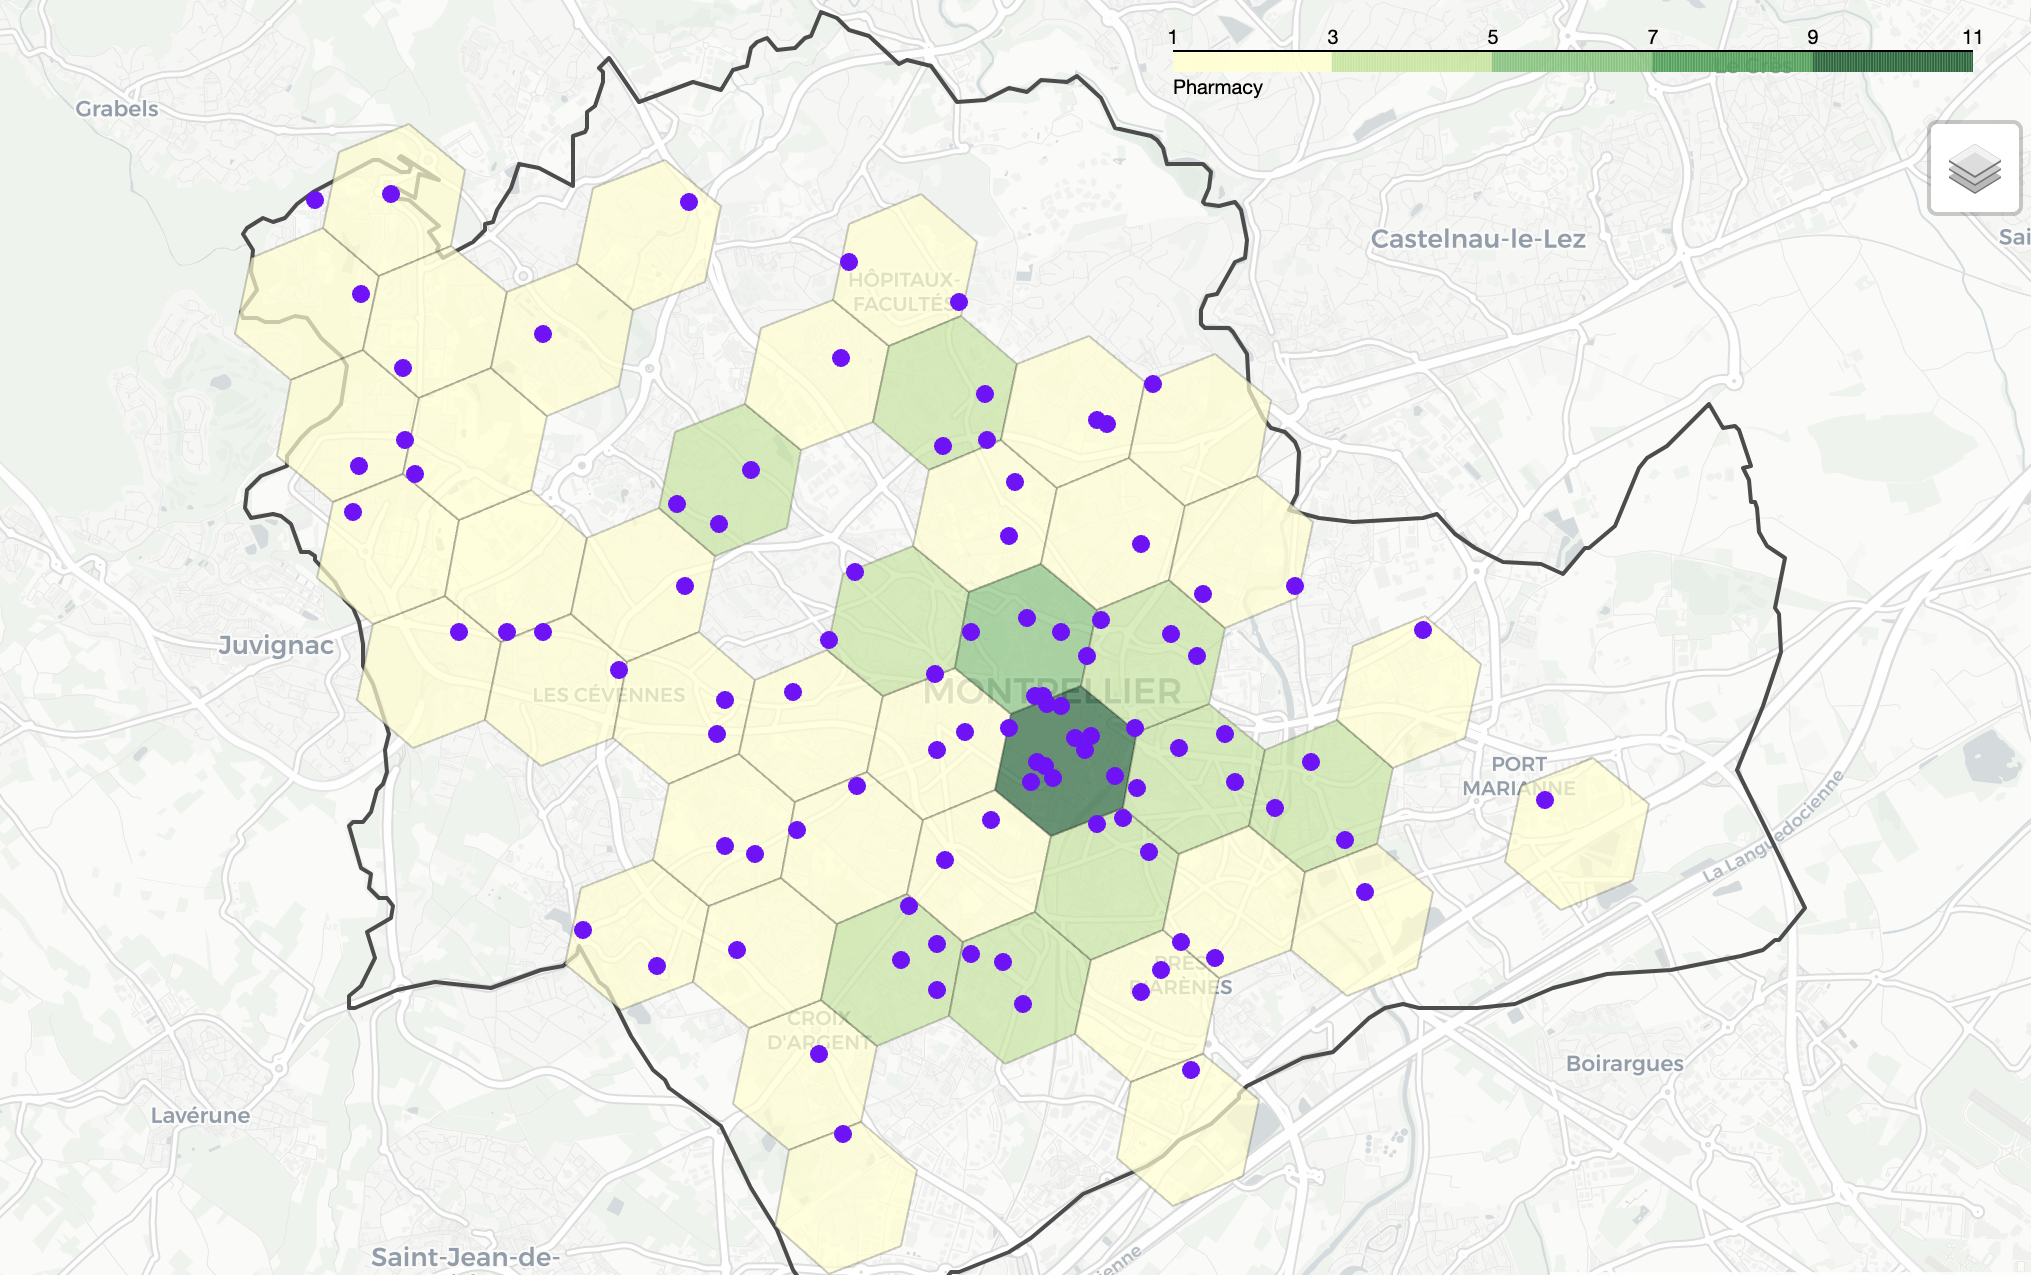

In [1]:
from IPython.display import Image

Image(filename="../resources/PharmacyMontpellier.png")